In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage
from os.path import expanduser
import glob
from matplotlib.ticker import MaxNLocator
from scipy.stats import spearmanr
import seg_metrics.seg_metrics as sg
import pickle
import matplotlib.patches as mpatches
from skimage import exposure
from scipy import ndimage
import nibabel as nib

In [2]:
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("SITK version:", sitk.__version__)
print("Scikit-image version:", skimage.__version__)

Python version: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
Numpy version: 1.26.2
Matplotlib version: 3.8.2
SITK version: 2.3.1
Scikit-image version: 0.22.0


/home/daryl/miniconda3/envs/py310/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
patient_id = 20

In [4]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
PREPROCESSED_MHA_DIR = '{}/mha/Patient{:02d}'.format(PREPROCESSED_BASE_DIR, patient_id)
PREPROCESSED_STACK_DIR = '{}/stack'.format(PREPROCESSED_BASE_DIR)

#### load the Jacobian determinant and calculate the ventilation map

In [5]:
image_exhale = sitk.GetArrayFromImage(sitk.ReadImage('{}/phase-exhale.mha'.format(PREPROCESSED_MHA_DIR)))
image_inhale = sitk.GetArrayFromImage(sitk.ReadImage('{}/phase-inhale.mha'.format(PREPROCESSED_MHA_DIR)))
mask_exhale = sitk.GetArrayFromImage(sitk.ReadImage('{}/mask-exhale.mha'.format(PREPROCESSED_MHA_DIR))).astype(bool)

jacobian_det = sitk.GetArrayFromImage(sitk.ReadImage('{}/vf_jac.mha'.format(PREPROCESSED_MHA_DIR)))
ventilation = jacobian_det-1.0
ventilation[~mask_exhale] = np.min(ventilation)

In [6]:
print(image_exhale.shape, image_inhale.shape, mask_exhale.shape, jacobian_det.shape, ventilation.shape)

(167, 512, 512) (167, 512, 512) (167, 512, 512) (167, 512, 512) (167, 512, 512)


In [7]:
prop = np.sum(np.array(jacobian_det[mask_exhale]) < 0) / len(jacobian_det[mask_exhale].ravel())
print('proportion of voxels with negative values in Jacobian determinant = {}'.format(round(prop, 2)))

proportion of voxels with negative values in Jacobian determinant = 0.01


#### resample the ventilation map so we can make a comparison with model predictions

#### normalise the ventilation map

In [8]:
normalised_ventilation = exposure.rescale_intensity(ventilation, in_range='image', out_range=(1e-3,1.))

#### apply a median filter

In [9]:
ventilation_filtered = ndimage.median_filter(normalised_ventilation, size=7)

#### quantise the ventilation map

In [10]:
percentile_high = np.percentile(ventilation_filtered[mask_exhale],70)
percentile_medium = np.percentile(ventilation_filtered[mask_exhale],30)

In [11]:
percentile_high,percentile_medium

(0.3916916400194168, 0.3323122262954712)

In [12]:
high_func_idxs = (ventilation_filtered>percentile_high)
med_func_idxs = (ventilation_filtered<=percentile_high) & (ventilation_filtered>=percentile_medium)
low_func_idxs = (ventilation_filtered<percentile_medium) & (ventilation_filtered>np.min(ventilation_filtered))

ventilation_label_arr = np.full_like(ventilation_filtered, 0)
ventilation_label_arr[high_func_idxs] = 1
ventilation_label_arr[med_func_idxs] = 2
ventilation_label_arr[low_func_idxs] = 3
ventilation_label_arr[~mask_exhale] = 0

#### load the PET ground truth

In [13]:
output_name = '{}/Patient{:02d}.npy'.format(PREPROCESSED_STACK_DIR, patient_id)
pt_arr = np.load(output_name)
print('loaded stack from {}'.format(output_name))

pet_labels_arr = pt_arr[3]

loaded stack from /mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch/stack/Patient20.npy


In [14]:
pet_labels_arr.shape

(250, 304, 304)

#### load the nnU-Net prediction

In [15]:
# load the predictions for Patient 20
DATASET_ID = 140
TEST_ID = 0

nnunet_prediction_arr = nib.load('/mnt/data/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_predictions/Dataset{}_RNSH_HFlung/post/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_ID, TEST_ID)).get_fdata()
nnunet_prediction_arr = np.moveaxis(nnunet_prediction_arr, -1, 0)

In [16]:
nnunet_prediction_arr.shape

(250, 304, 304)

#### visualise the images

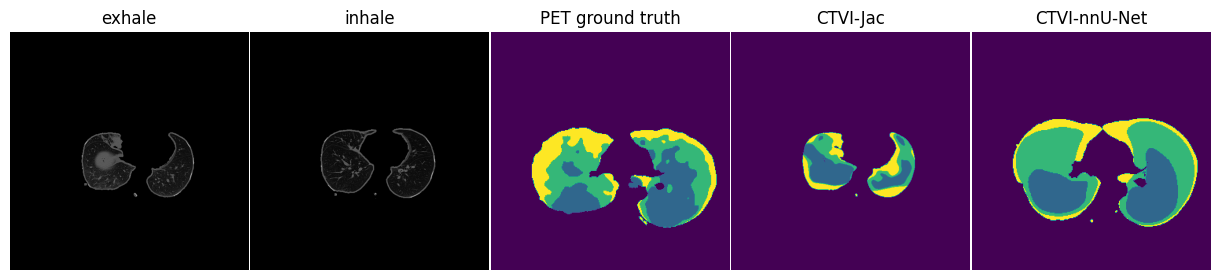

In [17]:
DISPLAY_IDX = 100

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15,4))
ax1.imshow(image_exhale[DISPLAY_IDX], cmap="gray")
ax1.set_title('exhale')
ax1.set_axis_off()

ax2.imshow(image_inhale[DISPLAY_IDX], cmap="gray")
ax2.set_title('inhale')
ax2.set_axis_off()

ax3.imshow(pet_labels_arr[DISPLAY_IDX])
ax3.set_title('PET ground truth')
ax3.set_axis_off()

ax4.imshow(ventilation_label_arr[DISPLAY_IDX])
ax4.set_title('CTVI-Jac')
ax4.set_axis_off()

ax5.imshow(nnunet_prediction_arr[DISPLAY_IDX])
ax5.set_title('CTVI-nnU-Net')
ax5.set_axis_off()

# fig.suptitle('Patient ID {}'.format(patient_id), x=0.1, y=1.0, fontsize=12, ha='left')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

#### write out the images for processing with EvaluateSegmentation

In [18]:
HOME_DIR = '/home/daryl'

sitk.WriteImage(sitk.GetImageFromArray(pet_labels_arr), '{}/pet-label.mha'.format(HOME_DIR))
sitk.WriteImage(sitk.GetImageFromArray(ventilation_label_arr), '{}/ctvi-jac-label.mha'.format(HOME_DIR))
sitk.WriteImage(sitk.GetImageFromArray(nnunet_prediction_arr), '{}/ctvi-nnunet.mha'.format(HOME_DIR))

#### compare segmentation similarity

In [19]:
from bs4 import BeautifulSoup

In [70]:
CTVI_JAC_EVAL = '{}/seg-metrics-ctvi-jac.xml'.format(HOME_DIR)
with open(CTVI_JAC_EVAL, 'r') as f:
    data = f.read()
ctvi_jac_eval = BeautifulSoup(data, "xml")

In [71]:
CTVI_NNUNET_EVAL = '{}/seg-metrics-ctvi-nnunet.xml'.format(HOME_DIR)
with open(CTVI_NNUNET_EVAL, 'r') as f:
    data = f.read()
ctvi_nnunet_eval = BeautifulSoup(data, "xml")

In [72]:
metrics_l = ['DICE','HDRFDST','MAHLNBS']
print('{: >10}{: >35}{: >15}{: >15}'.format('','','CTVI-Jac','CTVI-nnU-Net'))
for m in metrics_l:
    ctvi_jac_d = ctvi_jac_eval.find(m).attrs
    ctvi_nnunet_d = ctvi_nnunet_eval.find(m).attrs
    print('{: >10}{: >35}{: >15.2f}{: >15.2f}'.format(m, ctvi_jac_d['name'], float(ctvi_jac_d['value']), float(ctvi_nnunet_d['value'])))

                                                    CTVI-Jac   CTVI-nnU-Net
      DICE      Dice Coefficient (F1-Measure)           0.69           0.59
   HDRFDST                 Hausdorff Distance          70.14          70.89
   MAHLNBS               Mahanabolis Distance           0.29           0.15
